## 4

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import wandb

Loading Data

In [130]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

print(training_data.data.size())
print(training_data.targets.size()) 
print(test_data.data.size())
print(test_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


### 4.1

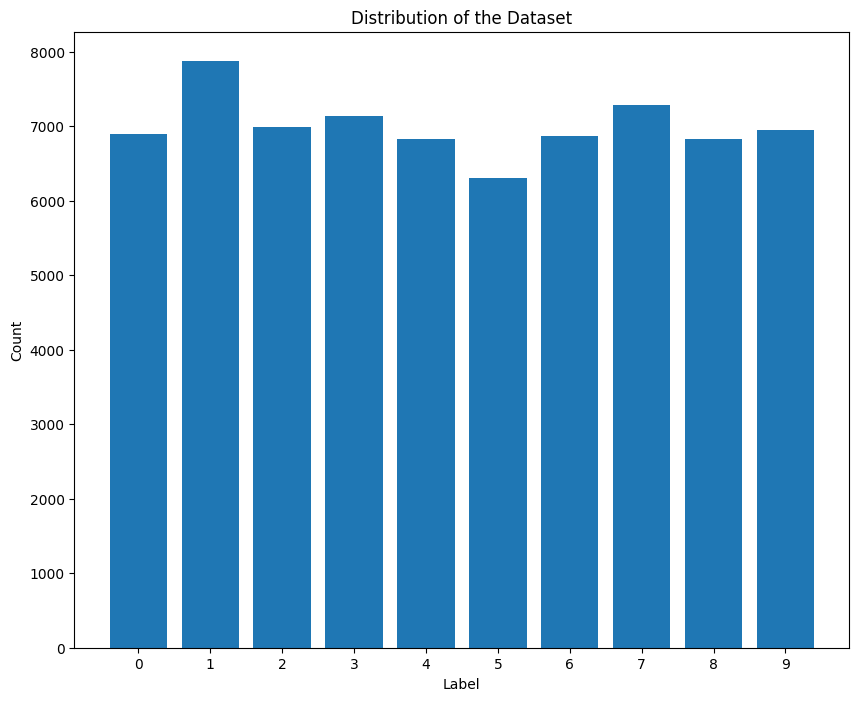

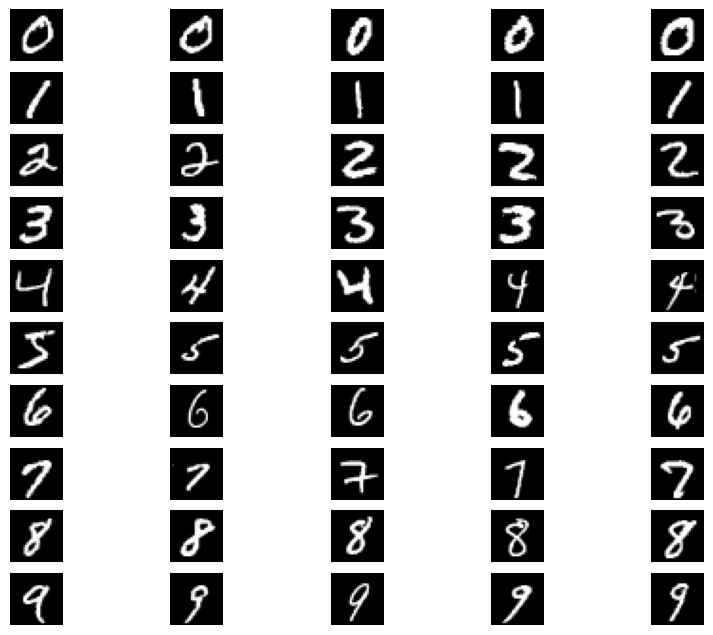

In [119]:
import matplotlib.pyplot as plt
import numpy as np

train_labels = training_data.targets
test_labels = test_data.targets

labels = torch.cat((train_labels, test_labels))
label_counts = torch.bincount(labels)
label_counts = label_counts.tolist()

fig = plt.figure(figsize=(10, 8))
plt.bar(range(10), label_counts)
plt.xticks(range(10))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of the Dataset')
plt.show()

fig = plt.figure(figsize=(10, 8))
for i in range(10):
    idx = np.where(labels == i)[0]

    for j in range(5):
        plt.subplot(10, 5, i*5+j+1)
        plt.imshow(training_data.data[idx[j]], cmap='gray')
        plt.axis('off')

plt.show()

Class-Imbalance

In [15]:
print('Class Imbalance Ratios for each label are as follows:')
print()

class_imbalance = []
for i in range(10):
    print('Label {}, Class Imbalance Ratio: {:.4f}'.format(i, label_counts[i] / len(labels)))

Class Imbalance Ratios for each label are as follows:

Label 0, Class Imbalance Ratio: 0.0986
Label 1, Class Imbalance Ratio: 0.1125
Label 2, Class Imbalance Ratio: 0.0999
Label 3, Class Imbalance Ratio: 0.1020
Label 4, Class Imbalance Ratio: 0.0975
Label 5, Class Imbalance Ratio: 0.0902
Label 6, Class Imbalance Ratio: 0.0982
Label 7, Class Imbalance Ratio: 0.1042
Label 8, Class Imbalance Ratio: 0.0975
Label 9, Class Imbalance Ratio: 0.0994


Splitting Data

In [131]:
train_ratio = 0.85
train_size = int(len(training_data) * train_ratio)
val_size = len(training_data) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, val_size])
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_data))

51000
9000
10000


### 4.2

CNN Class

In [103]:
class CNN(nn.Module):
    def __init__(self, alpha, kernel, padding):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel, 1, padding)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        shape = 28 - kernel + 2 * padding  + 1
        shape //= 2

        self.conv2 = nn.Conv2d(32, 64, kernel, 1, padding)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        shape = shape - kernel + 2 * padding  + 1
        shape //= 2

        self.dropout = nn.Dropout(alpha)
        self.fc1 = nn.Linear(64 * shape * shape, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x

Train and validate function

In [104]:
def train_cnn(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs):
    #model.train()

    for epoch in range(num_epochs):
        train_loss, correct = 0, 0

        for batch_idx, (data, target) in enumerate(train_dataloader):
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
         
        train_loss /= len(train_dataloader)
        accuracy = correct / len(train_dataloader.dataset)

        val_loss, val_accuracy = validate(val_dataloader, model, criterion)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    return train_loss, accuracy, val_loss, val_accuracy

def validate(val_dataloader, model, loss):
    #model.eval()
    val_loss, correct = 0, 0

    with torch.no_grad():
        for data, target in val_dataloader:
            output = model(data)
            val_loss += loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_dataloader)
    accuracy = correct / len(val_dataloader.dataset)

    return val_loss, accuracy

In [358]:
model = CNN(0.5, 3, 0)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_loss, train_acc, val_loss, val_acc = train_cnn(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs)
print('Train Loss: {:.4f}, Train Accuracy: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.4f}'.format(train_loss, train_acc, val_loss, val_acc))

Epoch [1/10], Train Loss: 0.3751, Train Accuracy: 0.8908, Val Loss: 0.1443, Val Accuracy: 0.9539
Epoch [2/10], Train Loss: 0.1070, Train Accuracy: 0.9674, Val Loss: 0.0910, Val Accuracy: 0.9704
Epoch [3/10], Train Loss: 0.0779, Train Accuracy: 0.9760, Val Loss: 0.0784, Val Accuracy: 0.9767
Epoch [4/10], Train Loss: 0.0634, Train Accuracy: 0.9812, Val Loss: 0.0674, Val Accuracy: 0.9776
Epoch [5/10], Train Loss: 0.0545, Train Accuracy: 0.9827, Val Loss: 0.0524, Val Accuracy: 0.9826
Epoch [6/10], Train Loss: 0.0482, Train Accuracy: 0.9848, Val Loss: 0.0545, Val Accuracy: 0.9826
Epoch [7/10], Train Loss: 0.0410, Train Accuracy: 0.9873, Val Loss: 0.0502, Val Accuracy: 0.9828
Epoch [8/10], Train Loss: 0.0366, Train Accuracy: 0.9887, Val Loss: 0.0494, Val Accuracy: 0.9846
Epoch [9/10], Train Loss: 0.0349, Train Accuracy: 0.9886, Val Loss: 0.0451, Val Accuracy: 0.9837
Epoch [10/10], Train Loss: 0.0305, Train Accuracy: 0.9905, Val Loss: 0.0449, Val Accuracy: 0.9863
Train Loss: 0.0305, Train Acc

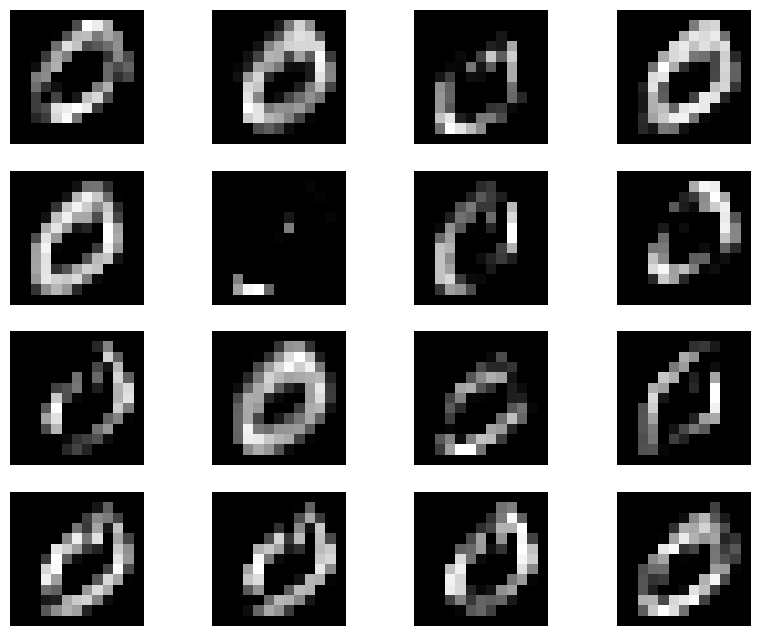

In [19]:
def plot_feature_maps():
    fig = plt.figure(figsize=(10, 8))
    model.eval()

    idx = np.where(labels == 0)[0][0]

    with torch.no_grad():
        output = model.conv1(training_data.data[idx].unsqueeze(0).unsqueeze(0).float())
        output = model.relu1(output)
        output = model.pool1(output)

    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(output[0][i], cmap='gray')
        plt.axis('off')

plot_feature_maps()

### 4.3

In [105]:
def train():
    config_defaults = {
        'learning_rate': 0.001,
        'epochs': 5,    
        'alpha': 0.5,
        'kernel': 3,
        'padding': 0,
        'batch_size': 256
    }

    wandb.init(project="Task 4", entity="siyaputtagunta", config=config_defaults)
    config = wandb.config

    model = CNN(config.alpha, config.kernel, config.padding)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    train_loss, train_acc, val_loss, val_acc = train_cnn(train_dataloader, val_dataloader, model, criterion, optimizer, config.epochs)
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

Hyperparameter Tuning

In [106]:
sweep_config = {
    'method': 'grid',
    'name': 'hyperparameter-tuning',
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'
    },
    'parameters': {
        'alpha': {
            'values': [0, 0.25, 0.5]
        },
        'kernel': {
            'values': [2, 3, 5]
        },
        'padding': {
            'values': [0, 1, 2]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project="Task4", entity="siyaputtagunta")
wandb.agent(sweep_id, train)

Create sweep with ID: t2myj3gu
Sweep URL: https://wandb.ai/siyaputtagunta/Task4/sweeps/t2myj3gu


wandb: Agent Starting Run: 1hq226s1 with config:
wandb: 	alpha: 0
wandb: 	kernel: 2
wandb: 	padding: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.5056, Train Accuracy: 0.8583, Val Loss: 0.1583, Val Accuracy: 0.9499
Epoch [2/5], Train Loss: 0.1220, Train Accuracy: 0.9639, Val Loss: 0.0916, Val Accuracy: 0.9731
Epoch [3/5], Train Loss: 0.0804, Train Accuracy: 0.9753, Val Loss: 0.0697, Val Accuracy: 0.9804
Epoch [4/5], Train Loss: 0.0628, Train Accuracy: 0.9807, Val Loss: 0.0605, Val Accuracy: 0.9826
Epoch [5/5], Train Loss: 0.0509, Train Accuracy: 0.9843, Val Loss: 0.0514, Val Accuracy: 0.9847


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98433
train_loss,0.05092
val_acc,0.98467
val_loss,0.0514


wandb: Agent Starting Run: cm18e12g with config:
wandb: 	alpha: 0
wandb: 	kernel: 2
wandb: 	padding: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.5484, Train Accuracy: 0.8384, Val Loss: 0.1934, Val Accuracy: 0.9411
Epoch [2/5], Train Loss: 0.1378, Train Accuracy: 0.9593, Val Loss: 0.0982, Val Accuracy: 0.9712
Epoch [3/5], Train Loss: 0.0859, Train Accuracy: 0.9731, Val Loss: 0.0874, Val Accuracy: 0.9726
Epoch [4/5], Train Loss: 0.0653, Train Accuracy: 0.9806, Val Loss: 0.0594, Val Accuracy: 0.9812
Epoch [5/5], Train Loss: 0.0533, Train Accuracy: 0.9840, Val Loss: 0.0643, Val Accuracy: 0.9804


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98396
train_loss,0.05327
val_acc,0.98044
val_loss,0.06428


wandb: Agent Starting Run: up3veb43 with config:
wandb: 	alpha: 0
wandb: 	kernel: 2
wandb: 	padding: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.5214, Train Accuracy: 0.8542, Val Loss: 0.1968, Val Accuracy: 0.9338
Epoch [2/5], Train Loss: 0.1283, Train Accuracy: 0.9614, Val Loss: 0.0890, Val Accuracy: 0.9737
Epoch [3/5], Train Loss: 0.0845, Train Accuracy: 0.9746, Val Loss: 0.0861, Val Accuracy: 0.9738
Epoch [4/5], Train Loss: 0.0646, Train Accuracy: 0.9804, Val Loss: 0.0652, Val Accuracy: 0.9789
Epoch [5/5], Train Loss: 0.0538, Train Accuracy: 0.9832, Val Loss: 0.0575, Val Accuracy: 0.9817


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98318
train_loss,0.0538
val_acc,0.98167
val_loss,0.05754


wandb: Agent Starting Run: ej7q7iyv with config:
wandb: 	alpha: 0
wandb: 	kernel: 3
wandb: 	padding: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3934, Train Accuracy: 0.8851, Val Loss: 0.1298, Val Accuracy: 0.9604
Epoch [2/5], Train Loss: 0.0926, Train Accuracy: 0.9720, Val Loss: 0.0748, Val Accuracy: 0.9786
Epoch [3/5], Train Loss: 0.0634, Train Accuracy: 0.9805, Val Loss: 0.0564, Val Accuracy: 0.9809
Epoch [4/5], Train Loss: 0.0477, Train Accuracy: 0.9853, Val Loss: 0.0425, Val Accuracy: 0.9876
Epoch [5/5], Train Loss: 0.0382, Train Accuracy: 0.9881, Val Loss: 0.0439, Val Accuracy: 0.9871


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98812
train_loss,0.03824
val_acc,0.98711
val_loss,0.04394


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ymutm7nb with config:
wandb: 	alpha: 0
wandb: 	kernel: 3
wandb: 	padding: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3668, Train Accuracy: 0.8924, Val Loss: 0.0935, Val Accuracy: 0.9707
Epoch [2/5], Train Loss: 0.0785, Train Accuracy: 0.9768, Val Loss: 0.0586, Val Accuracy: 0.9823
Epoch [3/5], Train Loss: 0.0540, Train Accuracy: 0.9833, Val Loss: 0.0520, Val Accuracy: 0.9846
Epoch [4/5], Train Loss: 0.0418, Train Accuracy: 0.9872, Val Loss: 0.0457, Val Accuracy: 0.9864
Epoch [5/5], Train Loss: 0.0346, Train Accuracy: 0.9895, Val Loss: 0.0387, Val Accuracy: 0.9879


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98947
train_loss,0.03456
val_acc,0.98789
val_loss,0.03867


wandb: Agent Starting Run: 4hu4bwcb with config:
wandb: 	alpha: 0
wandb: 	kernel: 3
wandb: 	padding: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3555, Train Accuracy: 0.8943, Val Loss: 0.1065, Val Accuracy: 0.9667
Epoch [2/5], Train Loss: 0.0825, Train Accuracy: 0.9756, Val Loss: 0.0867, Val Accuracy: 0.9747
Epoch [3/5], Train Loss: 0.0564, Train Accuracy: 0.9828, Val Loss: 0.0932, Val Accuracy: 0.9714
Epoch [4/5], Train Loss: 0.0422, Train Accuracy: 0.9871, Val Loss: 0.0505, Val Accuracy: 0.9853
Epoch [5/5], Train Loss: 0.0348, Train Accuracy: 0.9895, Val Loss: 0.0428, Val Accuracy: 0.9869


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98953
train_loss,0.03476
val_acc,0.98689
val_loss,0.04284


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h0q23c68 with config:
wandb: 	alpha: 0
wandb: 	kernel: 5
wandb: 	padding: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3423, Train Accuracy: 0.9060, Val Loss: 0.0927, Val Accuracy: 0.9726
Epoch [2/5], Train Loss: 0.0742, Train Accuracy: 0.9773, Val Loss: 0.0587, Val Accuracy: 0.9817
Epoch [3/5], Train Loss: 0.0507, Train Accuracy: 0.9846, Val Loss: 0.0493, Val Accuracy: 0.9834
Epoch [4/5], Train Loss: 0.0406, Train Accuracy: 0.9876, Val Loss: 0.0471, Val Accuracy: 0.9852
Epoch [5/5], Train Loss: 0.0319, Train Accuracy: 0.9904, Val Loss: 0.0353, Val Accuracy: 0.9889


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99043
train_loss,0.03191
val_acc,0.98889
val_loss,0.0353


wandb: Agent Starting Run: j9d7dmw9 with config:
wandb: 	alpha: 0
wandb: 	kernel: 5
wandb: 	padding: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3240, Train Accuracy: 0.9075, Val Loss: 0.0939, Val Accuracy: 0.9721
Epoch [2/5], Train Loss: 0.0730, Train Accuracy: 0.9772, Val Loss: 0.0559, Val Accuracy: 0.9821
Epoch [3/5], Train Loss: 0.0492, Train Accuracy: 0.9846, Val Loss: 0.0516, Val Accuracy: 0.9834
Epoch [4/5], Train Loss: 0.0388, Train Accuracy: 0.9880, Val Loss: 0.0399, Val Accuracy: 0.9873
Epoch [5/5], Train Loss: 0.0319, Train Accuracy: 0.9902, Val Loss: 0.0419, Val Accuracy: 0.9871


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99024
train_loss,0.03192
val_acc,0.98711
val_loss,0.04186


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6qk8feub with config:
wandb: 	alpha: 0
wandb: 	kernel: 5
wandb: 	padding: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3314, Train Accuracy: 0.8998, Val Loss: 0.1048, Val Accuracy: 0.9670
Epoch [2/5], Train Loss: 0.0770, Train Accuracy: 0.9764, Val Loss: 0.0574, Val Accuracy: 0.9830
Epoch [3/5], Train Loss: 0.0512, Train Accuracy: 0.9847, Val Loss: 0.0466, Val Accuracy: 0.9859
Epoch [4/5], Train Loss: 0.0381, Train Accuracy: 0.9885, Val Loss: 0.0409, Val Accuracy: 0.9879
Epoch [5/5], Train Loss: 0.0313, Train Accuracy: 0.9903, Val Loss: 0.0443, Val Accuracy: 0.9864


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99031
train_loss,0.03125
val_acc,0.98644
val_loss,0.04431


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hz6uhsdz with config:
wandb: 	alpha: 0.25
wandb: 	kernel: 2
wandb: 	padding: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.4746, Train Accuracy: 0.8660, Val Loss: 0.1649, Val Accuracy: 0.9511
Epoch [2/5], Train Loss: 0.1297, Train Accuracy: 0.9605, Val Loss: 0.0943, Val Accuracy: 0.9703
Epoch [3/5], Train Loss: 0.0890, Train Accuracy: 0.9734, Val Loss: 0.0779, Val Accuracy: 0.9738
Epoch [4/5], Train Loss: 0.0709, Train Accuracy: 0.9782, Val Loss: 0.0672, Val Accuracy: 0.9783
Epoch [5/5], Train Loss: 0.0583, Train Accuracy: 0.9815, Val Loss: 0.0579, Val Accuracy: 0.9819


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98153
train_loss,0.0583
val_acc,0.98189
val_loss,0.05793


wandb: Agent Starting Run: wztwgdqw with config:
wandb: 	alpha: 0.25
wandb: 	kernel: 2
wandb: 	padding: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.4550, Train Accuracy: 0.8672, Val Loss: 0.1573, Val Accuracy: 0.9526
Epoch [2/5], Train Loss: 0.1286, Train Accuracy: 0.9618, Val Loss: 0.0997, Val Accuracy: 0.9721
Epoch [3/5], Train Loss: 0.0903, Train Accuracy: 0.9720, Val Loss: 0.0802, Val Accuracy: 0.9754
Epoch [4/5], Train Loss: 0.0719, Train Accuracy: 0.9779, Val Loss: 0.0707, Val Accuracy: 0.9781
Epoch [5/5], Train Loss: 0.0592, Train Accuracy: 0.9811, Val Loss: 0.0647, Val Accuracy: 0.9801


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98106
train_loss,0.05915
val_acc,0.98011
val_loss,0.06473


wandb: Agent Starting Run: rp2dginq with config:
wandb: 	alpha: 0.25
wandb: 	kernel: 2
wandb: 	padding: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.4869, Train Accuracy: 0.8560, Val Loss: 0.1683, Val Accuracy: 0.9468
Epoch [2/5], Train Loss: 0.1342, Train Accuracy: 0.9592, Val Loss: 0.1064, Val Accuracy: 0.9670
Epoch [3/5], Train Loss: 0.0947, Train Accuracy: 0.9708, Val Loss: 0.0803, Val Accuracy: 0.9760
Epoch [4/5], Train Loss: 0.0738, Train Accuracy: 0.9775, Val Loss: 0.0754, Val Accuracy: 0.9757
Epoch [5/5], Train Loss: 0.0645, Train Accuracy: 0.9800, Val Loss: 0.0613, Val Accuracy: 0.9812


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98002
train_loss,0.06448
val_acc,0.98122
val_loss,0.06127


wandb: Agent Starting Run: uvcm9wub with config:
wandb: 	alpha: 0.25
wandb: 	kernel: 3
wandb: 	padding: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.4093, Train Accuracy: 0.8823, Val Loss: 0.1355, Val Accuracy: 0.9578
Epoch [2/5], Train Loss: 0.1032, Train Accuracy: 0.9684, Val Loss: 0.0790, Val Accuracy: 0.9759
Epoch [3/5], Train Loss: 0.0712, Train Accuracy: 0.9785, Val Loss: 0.0699, Val Accuracy: 0.9782
Epoch [4/5], Train Loss: 0.0553, Train Accuracy: 0.9830, Val Loss: 0.0562, Val Accuracy: 0.9824
Epoch [5/5], Train Loss: 0.0458, Train Accuracy: 0.9857, Val Loss: 0.0669, Val Accuracy: 0.9788


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98569
train_loss,0.04576
val_acc,0.97878
val_loss,0.0669


wandb: Agent Starting Run: 2vxqzr6j with config:
wandb: 	alpha: 0.25
wandb: 	kernel: 3
wandb: 	padding: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3812, Train Accuracy: 0.8908, Val Loss: 0.1165, Val Accuracy: 0.9656
Epoch [2/5], Train Loss: 0.0892, Train Accuracy: 0.9733, Val Loss: 0.0702, Val Accuracy: 0.9789
Epoch [3/5], Train Loss: 0.0618, Train Accuracy: 0.9810, Val Loss: 0.0597, Val Accuracy: 0.9828
Epoch [4/5], Train Loss: 0.0475, Train Accuracy: 0.9853, Val Loss: 0.0529, Val Accuracy: 0.9840
Epoch [5/5], Train Loss: 0.0403, Train Accuracy: 0.9877, Val Loss: 0.0428, Val Accuracy: 0.9864


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98775
train_loss,0.04033
val_acc,0.98644
val_loss,0.04278


wandb: Agent Starting Run: fo1g4bm1 with config:
wandb: 	alpha: 0.25
wandb: 	kernel: 3
wandb: 	padding: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3925, Train Accuracy: 0.8864, Val Loss: 0.1320, Val Accuracy: 0.9599
Epoch [2/5], Train Loss: 0.0959, Train Accuracy: 0.9711, Val Loss: 0.0739, Val Accuracy: 0.9771
Epoch [3/5], Train Loss: 0.0670, Train Accuracy: 0.9795, Val Loss: 0.0600, Val Accuracy: 0.9812
Epoch [4/5], Train Loss: 0.0538, Train Accuracy: 0.9832, Val Loss: 0.0520, Val Accuracy: 0.9826
Epoch [5/5], Train Loss: 0.0443, Train Accuracy: 0.9855, Val Loss: 0.0471, Val Accuracy: 0.9849


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98547
train_loss,0.04432
val_acc,0.98489
val_loss,0.04708


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dv76b6xy with config:
wandb: 	alpha: 0.25
wandb: 	kernel: 5
wandb: 	padding: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3386, Train Accuracy: 0.9021, Val Loss: 0.0963, Val Accuracy: 0.9689
Epoch [2/5], Train Loss: 0.0860, Train Accuracy: 0.9735, Val Loss: 0.0812, Val Accuracy: 0.9743
Epoch [3/5], Train Loss: 0.0594, Train Accuracy: 0.9819, Val Loss: 0.0592, Val Accuracy: 0.9798
Epoch [4/5], Train Loss: 0.0471, Train Accuracy: 0.9857, Val Loss: 0.0439, Val Accuracy: 0.9864
Epoch [5/5], Train Loss: 0.0372, Train Accuracy: 0.9884, Val Loss: 0.0429, Val Accuracy: 0.9862


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98837
train_loss,0.03723
val_acc,0.98622
val_loss,0.04293


wandb: Agent Starting Run: il7j1kzq with config:
wandb: 	alpha: 0.25
wandb: 	kernel: 5
wandb: 	padding: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3158, Train Accuracy: 0.9100, Val Loss: 0.1045, Val Accuracy: 0.9690
Epoch [2/5], Train Loss: 0.0757, Train Accuracy: 0.9767, Val Loss: 0.0661, Val Accuracy: 0.9813
Epoch [3/5], Train Loss: 0.0531, Train Accuracy: 0.9833, Val Loss: 0.0545, Val Accuracy: 0.9814
Epoch [4/5], Train Loss: 0.0408, Train Accuracy: 0.9872, Val Loss: 0.0504, Val Accuracy: 0.9862
Epoch [5/5], Train Loss: 0.0338, Train Accuracy: 0.9894, Val Loss: 0.0402, Val Accuracy: 0.9884


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98937
train_loss,0.03384
val_acc,0.98844
val_loss,0.0402


wandb: Agent Starting Run: exm2w7p7 with config:
wandb: 	alpha: 0.25
wandb: 	kernel: 5
wandb: 	padding: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3130, Train Accuracy: 0.9103, Val Loss: 0.0845, Val Accuracy: 0.9731
Epoch [2/5], Train Loss: 0.0682, Train Accuracy: 0.9781, Val Loss: 0.0550, Val Accuracy: 0.9833
Epoch [3/5], Train Loss: 0.0501, Train Accuracy: 0.9845, Val Loss: 0.0565, Val Accuracy: 0.9822
Epoch [4/5], Train Loss: 0.0380, Train Accuracy: 0.9879, Val Loss: 0.0412, Val Accuracy: 0.9874
Epoch [5/5], Train Loss: 0.0324, Train Accuracy: 0.9895, Val Loss: 0.0407, Val Accuracy: 0.9868


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98953
train_loss,0.03243
val_acc,0.98678
val_loss,0.04072


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: umw4ossc with config:
wandb: 	alpha: 0.5
wandb: 	kernel: 2
wandb: 	padding: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.4813, Train Accuracy: 0.8594, Val Loss: 0.1898, Val Accuracy: 0.9447
Epoch [2/5], Train Loss: 0.1513, Train Accuracy: 0.9533, Val Loss: 0.1288, Val Accuracy: 0.9589
Epoch [3/5], Train Loss: 0.1076, Train Accuracy: 0.9668, Val Loss: 0.1037, Val Accuracy: 0.9680
Epoch [4/5], Train Loss: 0.0898, Train Accuracy: 0.9728, Val Loss: 0.0922, Val Accuracy: 0.9718
Epoch [5/5], Train Loss: 0.0739, Train Accuracy: 0.9770, Val Loss: 0.0727, Val Accuracy: 0.9770


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.97696
train_loss,0.0739
val_acc,0.977
val_loss,0.07273


wandb: Agent Starting Run: 38usv1kh with config:
wandb: 	alpha: 0.5
wandb: 	kernel: 2
wandb: 	padding: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.5149, Train Accuracy: 0.8483, Val Loss: 0.1913, Val Accuracy: 0.9421
Epoch [2/5], Train Loss: 0.1454, Train Accuracy: 0.9555, Val Loss: 0.1127, Val Accuracy: 0.9647
Epoch [3/5], Train Loss: 0.1089, Train Accuracy: 0.9660, Val Loss: 0.0977, Val Accuracy: 0.9707
Epoch [4/5], Train Loss: 0.0866, Train Accuracy: 0.9725, Val Loss: 0.0789, Val Accuracy: 0.9757
Epoch [5/5], Train Loss: 0.0735, Train Accuracy: 0.9773, Val Loss: 0.0710, Val Accuracy: 0.9790


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.97729
train_loss,0.0735
val_acc,0.979
val_loss,0.07101


wandb: Agent Starting Run: wv7oqky9 with config:
wandb: 	alpha: 0.5
wandb: 	kernel: 2
wandb: 	padding: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.5034, Train Accuracy: 0.8527, Val Loss: 0.1951, Val Accuracy: 0.9378
Epoch [2/5], Train Loss: 0.1538, Train Accuracy: 0.9528, Val Loss: 0.1240, Val Accuracy: 0.9609
Epoch [3/5], Train Loss: 0.1145, Train Accuracy: 0.9641, Val Loss: 0.1050, Val Accuracy: 0.9680
Epoch [4/5], Train Loss: 0.0925, Train Accuracy: 0.9716, Val Loss: 0.0853, Val Accuracy: 0.9739
Epoch [5/5], Train Loss: 0.0776, Train Accuracy: 0.9752, Val Loss: 0.0753, Val Accuracy: 0.9769


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.97524
train_loss,0.07756
val_acc,0.97689
val_loss,0.0753


wandb: Agent Starting Run: 0rg7v1x7 with config:
wandb: 	alpha: 0.5
wandb: 	kernel: 3
wandb: 	padding: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3863, Train Accuracy: 0.8864, Val Loss: 0.1168, Val Accuracy: 0.9633
Epoch [2/5], Train Loss: 0.1031, Train Accuracy: 0.9681, Val Loss: 0.0835, Val Accuracy: 0.9746
Epoch [3/5], Train Loss: 0.0784, Train Accuracy: 0.9754, Val Loss: 0.0671, Val Accuracy: 0.9791
Epoch [4/5], Train Loss: 0.0633, Train Accuracy: 0.9800, Val Loss: 0.0607, Val Accuracy: 0.9807
Epoch [5/5], Train Loss: 0.0527, Train Accuracy: 0.9833, Val Loss: 0.0553, Val Accuracy: 0.9823


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98329
train_loss,0.05274
val_acc,0.98233
val_loss,0.05534


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ldw5ubvh with config:
wandb: 	alpha: 0.5
wandb: 	kernel: 3
wandb: 	padding: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3952, Train Accuracy: 0.8790, Val Loss: 0.1329, Val Accuracy: 0.9606
Epoch [2/5], Train Loss: 0.1079, Train Accuracy: 0.9679, Val Loss: 0.0873, Val Accuracy: 0.9728
Epoch [3/5], Train Loss: 0.0759, Train Accuracy: 0.9772, Val Loss: 0.0643, Val Accuracy: 0.9779
Epoch [4/5], Train Loss: 0.0611, Train Accuracy: 0.9811, Val Loss: 0.0629, Val Accuracy: 0.9804
Epoch [5/5], Train Loss: 0.0533, Train Accuracy: 0.9833, Val Loss: 0.0572, Val Accuracy: 0.9817


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98327
train_loss,0.05327
val_acc,0.98167
val_loss,0.05717


wandb: Agent Starting Run: 7bwwvuk6 with config:
wandb: 	alpha: 0.5
wandb: 	kernel: 3
wandb: 	padding: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.4012, Train Accuracy: 0.8783, Val Loss: 0.1276, Val Accuracy: 0.9604
Epoch [2/5], Train Loss: 0.1028, Train Accuracy: 0.9683, Val Loss: 0.0854, Val Accuracy: 0.9731
Epoch [3/5], Train Loss: 0.0736, Train Accuracy: 0.9772, Val Loss: 0.0631, Val Accuracy: 0.9800
Epoch [4/5], Train Loss: 0.0566, Train Accuracy: 0.9818, Val Loss: 0.0576, Val Accuracy: 0.9823
Epoch [5/5], Train Loss: 0.0473, Train Accuracy: 0.9843, Val Loss: 0.0535, Val Accuracy: 0.9833


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98431
train_loss,0.04734
val_acc,0.98333
val_loss,0.05347


wandb: Agent Starting Run: nyvdu1st with config:
wandb: 	alpha: 0.5
wandb: 	kernel: 5
wandb: 	padding: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3905, Train Accuracy: 0.8850, Val Loss: 0.1393, Val Accuracy: 0.9564
Epoch [2/5], Train Loss: 0.1101, Train Accuracy: 0.9659, Val Loss: 0.0862, Val Accuracy: 0.9751
Epoch [3/5], Train Loss: 0.0793, Train Accuracy: 0.9755, Val Loss: 0.0699, Val Accuracy: 0.9788
Epoch [4/5], Train Loss: 0.0631, Train Accuracy: 0.9806, Val Loss: 0.0612, Val Accuracy: 0.9797
Epoch [5/5], Train Loss: 0.0534, Train Accuracy: 0.9827, Val Loss: 0.0554, Val Accuracy: 0.9827


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98275
train_loss,0.05343
val_acc,0.98267
val_loss,0.05538


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fk1obfv3 with config:
wandb: 	alpha: 0.5
wandb: 	kernel: 5
wandb: 	padding: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3458, Train Accuracy: 0.8974, Val Loss: 0.1097, Val Accuracy: 0.9659
Epoch [2/5], Train Loss: 0.0915, Train Accuracy: 0.9723, Val Loss: 0.0672, Val Accuracy: 0.9787
Epoch [3/5], Train Loss: 0.0678, Train Accuracy: 0.9791, Val Loss: 0.0632, Val Accuracy: 0.9807
Epoch [4/5], Train Loss: 0.0548, Train Accuracy: 0.9828, Val Loss: 0.0534, Val Accuracy: 0.9839
Epoch [5/5], Train Loss: 0.0444, Train Accuracy: 0.9857, Val Loss: 0.0431, Val Accuracy: 0.9857


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98573
train_loss,0.04444
val_acc,0.98567
val_loss,0.04314


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7il2igmv with config:
wandb: 	alpha: 0.5
wandb: 	kernel: 5
wandb: 	padding: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3025, Train Accuracy: 0.9099, Val Loss: 0.0996, Val Accuracy: 0.9686
Epoch [2/5], Train Loss: 0.0790, Train Accuracy: 0.9759, Val Loss: 0.0751, Val Accuracy: 0.9764
Epoch [3/5], Train Loss: 0.0590, Train Accuracy: 0.9819, Val Loss: 0.0522, Val Accuracy: 0.9834
Epoch [4/5], Train Loss: 0.0483, Train Accuracy: 0.9848, Val Loss: 0.0539, Val Accuracy: 0.9831
Epoch [5/5], Train Loss: 0.0384, Train Accuracy: 0.9878, Val Loss: 0.0434, Val Accuracy: 0.9863


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98776
train_loss,0.03839
val_acc,0.98633
val_loss,0.04338


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [107]:
def train():
    config_defaults = {
        'learning_rate': 0.001,
        'epochs': 5,    
        'alpha': 0,
        'kernel': 5,
        'padding': 0,
        'batch_size': 256
    }

    wandb.init(project="Task 4", entity="siyaputtagunta", config=config_defaults)
    config = wandb.config

    model = CNN(config.alpha, config.kernel, config.padding)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    train_loss, train_acc, val_loss, val_acc = train_cnn(train_dataloader, val_dataloader, model, criterion, optimizer, config.epochs)
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

In [108]:
sweep_config = {
    'method': 'grid',
    'name': 'hyperparameter-tuning',
    'metric': {
      'name': 'val_acc',
      'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.01, 0.1]
        },
        'epochs': {
            'values': [5, 10]
        },
        'batch_size': {
            'values': [128, 256, 512]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project="Task4", entity="siyaputtagunta")
wandb.agent(sweep_id, train)

Create sweep with ID: 8p1szcuh
Sweep URL: https://wandb.ai/siyaputtagunta/Task4/sweeps/8p1szcuh


wandb: Agent Starting Run: vuhqr3bt with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3351, Train Accuracy: 0.9030, Val Loss: 0.0891, Val Accuracy: 0.9736
Epoch [2/5], Train Loss: 0.0784, Train Accuracy: 0.9756, Val Loss: 0.0676, Val Accuracy: 0.9797
Epoch [3/5], Train Loss: 0.0531, Train Accuracy: 0.9834, Val Loss: 0.0511, Val Accuracy: 0.9833
Epoch [4/5], Train Loss: 0.0394, Train Accuracy: 0.9879, Val Loss: 0.0480, Val Accuracy: 0.9840
Epoch [5/5], Train Loss: 0.0334, Train Accuracy: 0.9899, Val Loss: 0.0441, Val Accuracy: 0.9867


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98986
train_loss,0.03343
val_acc,0.98667
val_loss,0.04414


wandb: Agent Starting Run: jchzjuin with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.2126, Train Accuracy: 0.9336, Val Loss: 0.0642, Val Accuracy: 0.9816
Epoch [2/5], Train Loss: 0.0540, Train Accuracy: 0.9828, Val Loss: 0.0423, Val Accuracy: 0.9874
Epoch [3/5], Train Loss: 0.0406, Train Accuracy: 0.9881, Val Loss: 0.0490, Val Accuracy: 0.9862
Epoch [4/5], Train Loss: 0.0342, Train Accuracy: 0.9895, Val Loss: 0.0525, Val Accuracy: 0.9834
Epoch [5/5], Train Loss: 0.0305, Train Accuracy: 0.9904, Val Loss: 0.0582, Val Accuracy: 0.9842


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99035
train_loss,0.0305
val_acc,0.98422
val_loss,0.05815


wandb: Agent Starting Run: irbxejew with config:
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 4.9939, Train Accuracy: 0.1039, Val Loss: 2.3039, Val Accuracy: 0.1143
Epoch [2/5], Train Loss: 2.3048, Train Accuracy: 0.1081, Val Loss: 2.3058, Val Accuracy: 0.1028
Epoch [3/5], Train Loss: 2.3050, Train Accuracy: 0.1049, Val Loss: 2.3039, Val Accuracy: 0.1143
Epoch [4/5], Train Loss: 2.3055, Train Accuracy: 0.1042, Val Loss: 2.3048, Val Accuracy: 0.1143
Epoch [5/5], Train Loss: 2.3055, Train Accuracy: 0.1059, Val Loss: 2.3061, Val Accuracy: 0.0940


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.10586
train_loss,2.30552
val_acc,0.094
val_loss,2.30613


wandb: Agent Starting Run: ydmfaykf with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/10], Train Loss: 0.3637, Train Accuracy: 0.8973, Val Loss: 0.1239, Val Accuracy: 0.9629
Epoch [2/10], Train Loss: 0.0816, Train Accuracy: 0.9752, Val Loss: 0.0742, Val Accuracy: 0.9767
Epoch [3/10], Train Loss: 0.0521, Train Accuracy: 0.9838, Val Loss: 0.0507, Val Accuracy: 0.9839
Epoch [4/10], Train Loss: 0.0416, Train Accuracy: 0.9874, Val Loss: 0.0432, Val Accuracy: 0.9858
Epoch [5/10], Train Loss: 0.0334, Train Accuracy: 0.9894, Val Loss: 0.0423, Val Accuracy: 0.9861
Epoch [6/10], Train Loss: 0.0271, Train Accuracy: 0.9918, Val Loss: 0.0488, Val Accuracy: 0.9838
Epoch [7/10], Train Loss: 0.0239, Train Accuracy: 0.9923, Val Loss: 0.0362, Val Accuracy: 0.9881
Epoch [8/10], Train Loss: 0.0188, Train Accuracy: 0.9942, Val Loss: 0.0373, Val Accuracy: 0.9901
Epoch [9/10], Train Loss: 0.0165, Train Accuracy: 0.9945, Val Loss: 0.0371, Val Accuracy: 0.9882
Epoch [10/10], Train Loss: 0.0152, Train Accuracy: 0.9952, Val Loss: 0.0347, Val Accuracy: 0.9891


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99516
train_loss,0.01517
val_acc,0.98911
val_loss,0.03473


wandb: Agent Starting Run: vzml5ghk with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/10], Train Loss: 0.2752, Train Accuracy: 0.9185, Val Loss: 0.0563, Val Accuracy: 0.9811
Epoch [2/10], Train Loss: 0.0566, Train Accuracy: 0.9822, Val Loss: 0.0528, Val Accuracy: 0.9839
Epoch [3/10], Train Loss: 0.0437, Train Accuracy: 0.9867, Val Loss: 0.0621, Val Accuracy: 0.9812
Epoch [4/10], Train Loss: 0.0354, Train Accuracy: 0.9890, Val Loss: 0.0608, Val Accuracy: 0.9830
Epoch [5/10], Train Loss: 0.0311, Train Accuracy: 0.9902, Val Loss: 0.0587, Val Accuracy: 0.9819
Epoch [6/10], Train Loss: 0.0301, Train Accuracy: 0.9909, Val Loss: 0.0547, Val Accuracy: 0.9841
Epoch [7/10], Train Loss: 0.0282, Train Accuracy: 0.9909, Val Loss: 0.0885, Val Accuracy: 0.9768
Epoch [8/10], Train Loss: 0.0332, Train Accuracy: 0.9894, Val Loss: 0.0436, Val Accuracy: 0.9859
Epoch [9/10], Train Loss: 0.0236, Train Accuracy: 0.9927, Val Loss: 0.0674, Val Accuracy: 0.9829
Epoch [10/10], Train Loss: 0.0254, Train Accuracy: 0.9923, Val Loss: 0.0441, Val Accuracy: 0.9864


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99229
train_loss,0.02543
val_acc,0.98644
val_loss,0.04411


wandb: Agent Starting Run: cvisq19u with config:
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/10], Train Loss: 4.7634, Train Accuracy: 0.1014, Val Loss: 2.3058, Val Accuracy: 0.0967
Epoch [2/10], Train Loss: 2.3049, Train Accuracy: 0.1059, Val Loss: 2.3043, Val Accuracy: 0.1028
Epoch [3/10], Train Loss: 2.3047, Train Accuracy: 0.1043, Val Loss: 2.3043, Val Accuracy: 0.0986
Epoch [4/10], Train Loss: 2.3047, Train Accuracy: 0.1069, Val Loss: 2.3082, Val Accuracy: 0.1028
Epoch [5/10], Train Loss: 2.3048, Train Accuracy: 0.1064, Val Loss: 2.3017, Val Accuracy: 0.1143
Epoch [6/10], Train Loss: 2.3051, Train Accuracy: 0.1062, Val Loss: 2.3065, Val Accuracy: 0.0967
Epoch [7/10], Train Loss: 2.3061, Train Accuracy: 0.1043, Val Loss: 2.3049, Val Accuracy: 0.1028
Epoch [8/10], Train Loss: 2.3053, Train Accuracy: 0.1033, Val Loss: 2.3051, Val Accuracy: 0.0967
Epoch [9/10], Train Loss: 2.3053, Train Accuracy: 0.1075, Val Loss: 2.3038, Val Accuracy: 0.1074
Epoch [10/10], Train Loss: 2.3053, Train Accuracy: 0.1075, Val Loss: 2.3050, Val Accuracy: 0.1143


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.10749
train_loss,2.30527
val_acc,0.11433
val_loss,2.30502


wandb: Agent Starting Run: f48c05i8 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3280, Train Accuracy: 0.9090, Val Loss: 0.1035, Val Accuracy: 0.9686
Epoch [2/5], Train Loss: 0.0744, Train Accuracy: 0.9776, Val Loss: 0.0708, Val Accuracy: 0.9782
Epoch [3/5], Train Loss: 0.0503, Train Accuracy: 0.9845, Val Loss: 0.0472, Val Accuracy: 0.9851
Epoch [4/5], Train Loss: 0.0387, Train Accuracy: 0.9877, Val Loss: 0.0415, Val Accuracy: 0.9864
Epoch [5/5], Train Loss: 0.0306, Train Accuracy: 0.9902, Val Loss: 0.0418, Val Accuracy: 0.9868


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99024
train_loss,0.03059
val_acc,0.98678
val_loss,0.04183


wandb: Agent Starting Run: jldd3glx with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.2961, Train Accuracy: 0.9070, Val Loss: 0.1080, Val Accuracy: 0.9693
Epoch [2/5], Train Loss: 0.0708, Train Accuracy: 0.9784, Val Loss: 0.0694, Val Accuracy: 0.9782
Epoch [3/5], Train Loss: 0.0533, Train Accuracy: 0.9838, Val Loss: 0.0743, Val Accuracy: 0.9782
Epoch [4/5], Train Loss: 0.0524, Train Accuracy: 0.9838, Val Loss: 0.0531, Val Accuracy: 0.9834
Epoch [5/5], Train Loss: 0.0411, Train Accuracy: 0.9866, Val Loss: 0.0684, Val Accuracy: 0.9817


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98665
train_loss,0.04113
val_acc,0.98167
val_loss,0.06837


wandb: Agent Starting Run: 2mnndsew with config:
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 3.9945, Train Accuracy: 0.1041, Val Loss: 2.3036, Val Accuracy: 0.1028
Epoch [2/5], Train Loss: 2.3049, Train Accuracy: 0.1058, Val Loss: 2.3014, Val Accuracy: 0.1027
Epoch [3/5], Train Loss: 2.3046, Train Accuracy: 0.1054, Val Loss: 2.3031, Val Accuracy: 0.1028
Epoch [4/5], Train Loss: 2.3049, Train Accuracy: 0.1060, Val Loss: 2.3027, Val Accuracy: 0.1143
Epoch [5/5], Train Loss: 2.3046, Train Accuracy: 0.1046, Val Loss: 2.3024, Val Accuracy: 0.1143


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.10463
train_loss,2.30465
val_acc,0.11433
val_loss,2.30236


wandb: Agent Starting Run: 5t0ygeo4 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/10], Train Loss: 0.3226, Train Accuracy: 0.9072, Val Loss: 0.0929, Val Accuracy: 0.9734
Epoch [2/10], Train Loss: 0.0738, Train Accuracy: 0.9774, Val Loss: 0.0653, Val Accuracy: 0.9806
Epoch [3/10], Train Loss: 0.0522, Train Accuracy: 0.9846, Val Loss: 0.0488, Val Accuracy: 0.9844
Epoch [4/10], Train Loss: 0.0380, Train Accuracy: 0.9882, Val Loss: 0.0457, Val Accuracy: 0.9857
Epoch [5/10], Train Loss: 0.0320, Train Accuracy: 0.9904, Val Loss: 0.0348, Val Accuracy: 0.9899
Epoch [6/10], Train Loss: 0.0264, Train Accuracy: 0.9918, Val Loss: 0.0364, Val Accuracy: 0.9889
Epoch [7/10], Train Loss: 0.0205, Train Accuracy: 0.9939, Val Loss: 0.0329, Val Accuracy: 0.9896
Epoch [8/10], Train Loss: 0.0169, Train Accuracy: 0.9948, Val Loss: 0.0317, Val Accuracy: 0.9893
Epoch [9/10], Train Loss: 0.0139, Train Accuracy: 0.9955, Val Loss: 0.0301, Val Accuracy: 0.9909
Epoch [10/10], Train Loss: 0.0118, Train Accuracy: 0.9963, Val Loss: 0.0299, Val Accuracy: 0.9916


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99631
train_loss,0.01182
val_acc,0.99156
val_loss,0.02992


wandb: Agent Starting Run: u0nmujph with config:
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/10], Train Loss: 0.2129, Train Accuracy: 0.9319, Val Loss: 0.0703, Val Accuracy: 0.9794
Epoch [2/10], Train Loss: 0.0515, Train Accuracy: 0.9843, Val Loss: 0.0505, Val Accuracy: 0.9841
Epoch [3/10], Train Loss: 0.0374, Train Accuracy: 0.9885, Val Loss: 0.0451, Val Accuracy: 0.9856
Epoch [4/10], Train Loss: 0.0361, Train Accuracy: 0.9888, Val Loss: 0.0714, Val Accuracy: 0.9813
Epoch [5/10], Train Loss: 0.0312, Train Accuracy: 0.9905, Val Loss: 0.0502, Val Accuracy: 0.9850
Epoch [6/10], Train Loss: 0.0234, Train Accuracy: 0.9929, Val Loss: 0.0552, Val Accuracy: 0.9844
Epoch [7/10], Train Loss: 0.0244, Train Accuracy: 0.9925, Val Loss: 0.0631, Val Accuracy: 0.9838
Epoch [8/10], Train Loss: 0.0250, Train Accuracy: 0.9923, Val Loss: 0.0568, Val Accuracy: 0.9877
Epoch [9/10], Train Loss: 0.0224, Train Accuracy: 0.9931, Val Loss: 0.0576, Val Accuracy: 0.9870
Epoch [10/10], Train Loss: 0.0236, Train Accuracy: 0.9924, Val Loss: 0.0551, Val Accuracy: 0.9872


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99243
train_loss,0.02365
val_acc,0.98722
val_loss,0.05513


wandb: Agent Starting Run: 4jom18je with config:
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/10], Train Loss: 7.9299, Train Accuracy: 0.1051, Val Loss: 2.3030, Val Accuracy: 0.1028
Epoch [2/10], Train Loss: 2.3039, Train Accuracy: 0.1053, Val Loss: 2.3022, Val Accuracy: 0.1027
Epoch [3/10], Train Loss: 2.3042, Train Accuracy: 0.1071, Val Loss: 2.3060, Val Accuracy: 0.1028
Epoch [4/10], Train Loss: 2.3055, Train Accuracy: 0.1034, Val Loss: 2.3047, Val Accuracy: 0.1143
Epoch [5/10], Train Loss: 2.3050, Train Accuracy: 0.1064, Val Loss: 2.3033, Val Accuracy: 0.1028
Epoch [6/10], Train Loss: 2.3047, Train Accuracy: 0.1062, Val Loss: 2.3015, Val Accuracy: 0.1143
Epoch [7/10], Train Loss: 2.3051, Train Accuracy: 0.1061, Val Loss: 2.3032, Val Accuracy: 0.1143
Epoch [8/10], Train Loss: 2.3048, Train Accuracy: 0.1058, Val Loss: 2.3056, Val Accuracy: 0.0940
Epoch [9/10], Train Loss: 2.3058, Train Accuracy: 0.1057, Val Loss: 2.3075, Val Accuracy: 0.1028
Epoch [10/10], Train Loss: 2.3063, Train Accuracy: 0.1039, Val Loss: 2.3012, Val Accuracy: 0.1074


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.1039
train_loss,2.30628
val_acc,0.10744
val_loss,2.30122


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y76hep9s with config:
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3463, Train Accuracy: 0.8996, Val Loss: 0.1160, Val Accuracy: 0.9633
Epoch [2/5], Train Loss: 0.0799, Train Accuracy: 0.9764, Val Loss: 0.0618, Val Accuracy: 0.9799
Epoch [3/5], Train Loss: 0.0531, Train Accuracy: 0.9835, Val Loss: 0.0550, Val Accuracy: 0.9824
Epoch [4/5], Train Loss: 0.0415, Train Accuracy: 0.9875, Val Loss: 0.0557, Val Accuracy: 0.9830
Epoch [5/5], Train Loss: 0.0320, Train Accuracy: 0.9895, Val Loss: 0.0405, Val Accuracy: 0.9871


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98955
train_loss,0.03199
val_acc,0.98711
val_loss,0.04054


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1qd6dvis with config:
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 0.3690, Train Accuracy: 0.8781, Val Loss: 0.0746, Val Accuracy: 0.9792
Epoch [2/5], Train Loss: 0.0699, Train Accuracy: 0.9785, Val Loss: 0.0699, Val Accuracy: 0.9788
Epoch [3/5], Train Loss: 0.0562, Train Accuracy: 0.9825, Val Loss: 0.0560, Val Accuracy: 0.9824
Epoch [4/5], Train Loss: 0.0484, Train Accuracy: 0.9845, Val Loss: 0.0671, Val Accuracy: 0.9813
Epoch [5/5], Train Loss: 0.0403, Train Accuracy: 0.9871, Val Loss: 0.0576, Val Accuracy: 0.9830


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.98714
train_loss,0.04035
val_acc,0.983
val_loss,0.05763


wandb: Agent Starting Run: 1ly2cbna with config:
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5], Train Loss: 5.6845, Train Accuracy: 0.1070, Val Loss: 2.3030, Val Accuracy: 0.1028
Epoch [2/5], Train Loss: 2.3048, Train Accuracy: 0.1062, Val Loss: 2.3051, Val Accuracy: 0.0997
Epoch [3/5], Train Loss: 2.3047, Train Accuracy: 0.1065, Val Loss: 2.3039, Val Accuracy: 0.1028
Epoch [4/5], Train Loss: 2.3047, Train Accuracy: 0.1060, Val Loss: 2.3039, Val Accuracy: 0.0986
Epoch [5/5], Train Loss: 2.3053, Train Accuracy: 0.1054, Val Loss: 2.3031, Val Accuracy: 0.1143


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.10539
train_loss,2.30532
val_acc,0.11433
val_loss,2.30307


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oqb0zra0 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/10], Train Loss: 0.3228, Train Accuracy: 0.9102, Val Loss: 0.0901, Val Accuracy: 0.9720
Epoch [2/10], Train Loss: 0.0742, Train Accuracy: 0.9780, Val Loss: 0.0701, Val Accuracy: 0.9793
Epoch [3/10], Train Loss: 0.0509, Train Accuracy: 0.9845, Val Loss: 0.0559, Val Accuracy: 0.9831
Epoch [4/10], Train Loss: 0.0383, Train Accuracy: 0.9880, Val Loss: 0.0372, Val Accuracy: 0.9893
Epoch [5/10], Train Loss: 0.0300, Train Accuracy: 0.9908, Val Loss: 0.0344, Val Accuracy: 0.9899
Epoch [6/10], Train Loss: 0.0258, Train Accuracy: 0.9922, Val Loss: 0.0344, Val Accuracy: 0.9884
Epoch [7/10], Train Loss: 0.0226, Train Accuracy: 0.9930, Val Loss: 0.0428, Val Accuracy: 0.9863
Epoch [8/10], Train Loss: 0.0190, Train Accuracy: 0.9941, Val Loss: 0.0334, Val Accuracy: 0.9901
Epoch [9/10], Train Loss: 0.0137, Train Accuracy: 0.9959, Val Loss: 0.0337, Val Accuracy: 0.9914
Epoch [10/10], Train Loss: 0.0116, Train Accuracy: 0.9964, Val Loss: 0.0326, Val Accuracy: 0.9907


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99635
train_loss,0.01159
val_acc,0.99067
val_loss,0.03261


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2sig0eb9 with config:
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/10], Train Loss: 0.2247, Train Accuracy: 0.9304, Val Loss: 0.0869, Val Accuracy: 0.9730
Epoch [2/10], Train Loss: 0.0549, Train Accuracy: 0.9830, Val Loss: 0.0542, Val Accuracy: 0.9847
Epoch [3/10], Train Loss: 0.0394, Train Accuracy: 0.9878, Val Loss: 0.0535, Val Accuracy: 0.9857
Epoch [4/10], Train Loss: 0.0353, Train Accuracy: 0.9892, Val Loss: 0.0426, Val Accuracy: 0.9868
Epoch [5/10], Train Loss: 0.0309, Train Accuracy: 0.9900, Val Loss: 0.0469, Val Accuracy: 0.9872
Epoch [6/10], Train Loss: 0.0280, Train Accuracy: 0.9915, Val Loss: 0.0614, Val Accuracy: 0.9843
Epoch [7/10], Train Loss: 0.0258, Train Accuracy: 0.9918, Val Loss: 0.0540, Val Accuracy: 0.9868
Epoch [8/10], Train Loss: 0.0226, Train Accuracy: 0.9928, Val Loss: 0.0687, Val Accuracy: 0.9828
Epoch [9/10], Train Loss: 0.0233, Train Accuracy: 0.9926, Val Loss: 0.0593, Val Accuracy: 0.9860
Epoch [10/10], Train Loss: 0.0245, Train Accuracy: 0.9923, Val Loss: 0.0591, Val Accuracy: 0.9869


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.99229
train_loss,0.02454
val_acc,0.98689
val_loss,0.05912


wandb: Agent Starting Run: 4d41pxnu with config:
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	learning_rate: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/10], Train Loss: 7.8489, Train Accuracy: 0.1038, Val Loss: 2.3041, Val Accuracy: 0.1074
Epoch [2/10], Train Loss: 2.3051, Train Accuracy: 0.1050, Val Loss: 2.3031, Val Accuracy: 0.1028
Epoch [3/10], Train Loss: 2.3052, Train Accuracy: 0.1029, Val Loss: 2.3073, Val Accuracy: 0.0967
Epoch [4/10], Train Loss: 2.3056, Train Accuracy: 0.1050, Val Loss: 2.3082, Val Accuracy: 0.1028
Epoch [5/10], Train Loss: 2.3056, Train Accuracy: 0.1041, Val Loss: 2.3022, Val Accuracy: 0.1143
Epoch [6/10], Train Loss: 2.3049, Train Accuracy: 0.1043, Val Loss: 2.3007, Val Accuracy: 0.1143
Epoch [7/10], Train Loss: 2.3052, Train Accuracy: 0.1061, Val Loss: 2.3030, Val Accuracy: 0.1074
Epoch [8/10], Train Loss: 2.3053, Train Accuracy: 0.1059, Val Loss: 2.3043, Val Accuracy: 0.1143
Epoch [9/10], Train Loss: 2.3053, Train Accuracy: 0.1039, Val Loss: 2.3043, Val Accuracy: 0.1028
Epoch [10/10], Train Loss: 2.3050, Train Accuracy: 0.1047, Val Loss: 2.3046, Val Accuracy: 0.1028


train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
train_acc,0.10471
train_loss,2.305
val_acc,0.10278
val_loss,2.30463


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Best Hyperparameters:
- Dropout Ratio: 0
- Kernel Size: 5
- Padding: 0
- Learning Rate: 0.001
- Batch size: 256
- Epochs: 10

### 4.4

In [110]:
model = CNN(0, 5, 0)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 256
epoch = 10

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

train_cnn(train_dataloader, val_dataloader, model, criterion, optimizer, epoch)

Epoch [1/10], Train Loss: 0.3286, Train Accuracy: 0.9084, Val Loss: 0.0854, Val Accuracy: 0.9732
Epoch [2/10], Train Loss: 0.0765, Train Accuracy: 0.9766, Val Loss: 0.0651, Val Accuracy: 0.9801
Epoch [3/10], Train Loss: 0.0492, Train Accuracy: 0.9847, Val Loss: 0.0458, Val Accuracy: 0.9849
Epoch [4/10], Train Loss: 0.0370, Train Accuracy: 0.9887, Val Loss: 0.0392, Val Accuracy: 0.9881
Epoch [5/10], Train Loss: 0.0315, Train Accuracy: 0.9900, Val Loss: 0.0372, Val Accuracy: 0.9890
Epoch [6/10], Train Loss: 0.0256, Train Accuracy: 0.9917, Val Loss: 0.0364, Val Accuracy: 0.9887
Epoch [7/10], Train Loss: 0.0213, Train Accuracy: 0.9932, Val Loss: 0.0323, Val Accuracy: 0.9901
Epoch [8/10], Train Loss: 0.0180, Train Accuracy: 0.9947, Val Loss: 0.0296, Val Accuracy: 0.9901
Epoch [9/10], Train Loss: 0.0153, Train Accuracy: 0.9955, Val Loss: 0.0362, Val Accuracy: 0.9881
Epoch [10/10], Train Loss: 0.0121, Train Accuracy: 0.9964, Val Loss: 0.0293, Val Accuracy: 0.9911


(0.012126954381528776,
 0.9963725490196078,
 0.02933571486371673,
 0.9911111111111112)

Testing

In [111]:
loss, accuracy = validate(test_dataloader, model, criterion)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.0269, Test Accuracy: 0.9920


In [112]:
from sklearn.metrics import confusion_matrix, classification_report

def test():
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for data, target in test_dataloader:
            output = model(data)
            preds.extend(output.argmax(dim=1, keepdim=True).squeeze().tolist())
            targets.extend(target.tolist())

    print(classification_report(targets, preds))

    return targets, preds

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



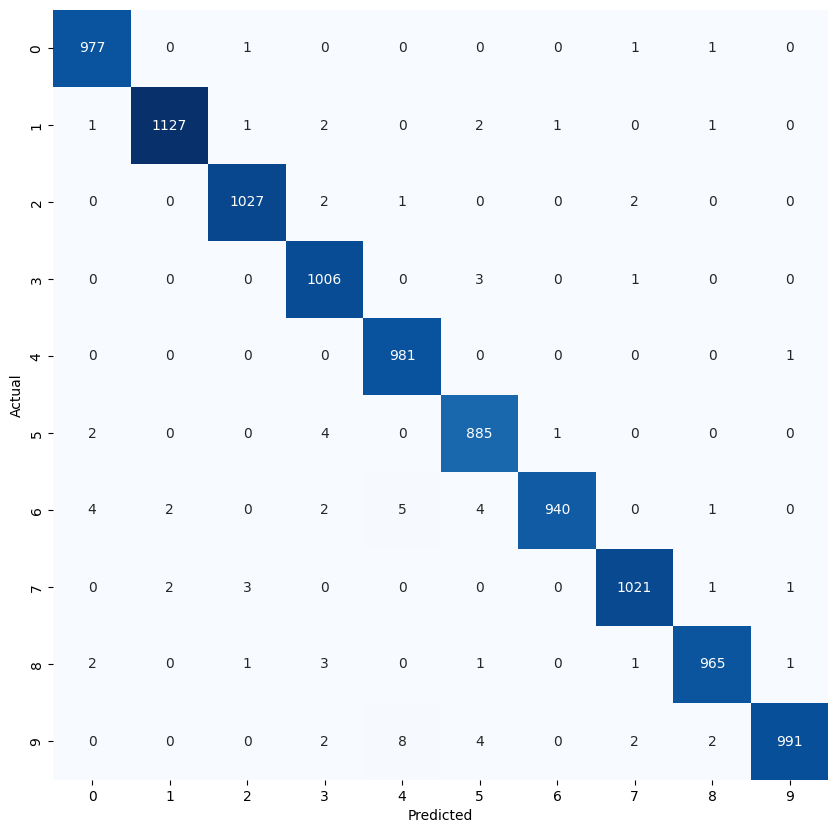

In [113]:
import seaborn as sns

targets, preds = test()

cm = confusion_matrix(targets, preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 4.5

Loading Data

In [150]:
import scipy.io

mat = scipy.io.loadmat('mnist-with-awgn.mat')

x_train = torch.from_numpy(mat['train_x']).float()
y_train = torch.from_numpy(mat['train_y']).long()
x_test = torch.from_numpy(mat['test_x']).float()
y_test = torch.from_numpy(mat['test_y']).long()

x_train = x_train.reshape(-1, 1, 28, 28)
x_train /= 255

x_test = x_test.reshape(-1, 1, 28, 28)
x_test /= 255

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000])


Splitting Data

In [151]:
train_ratio = 0.85
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Training

In [116]:
model = CNN(0, 5, 0)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_cnn(train_dataloader, val_dataloader, model, criterion, optimizer, 10)

Epoch [1/10], Train Loss: 0.4425, Train Accuracy: 0.8713, Val Loss: 0.1713, Val Accuracy: 0.9477
Epoch [2/10], Train Loss: 0.1274, Train Accuracy: 0.9605, Val Loss: 0.1167, Val Accuracy: 0.9629
Epoch [3/10], Train Loss: 0.0875, Train Accuracy: 0.9722, Val Loss: 0.0998, Val Accuracy: 0.9702
Epoch [4/10], Train Loss: 0.0709, Train Accuracy: 0.9776, Val Loss: 0.0975, Val Accuracy: 0.9692
Epoch [5/10], Train Loss: 0.0584, Train Accuracy: 0.9812, Val Loss: 0.0830, Val Accuracy: 0.9732
Epoch [6/10], Train Loss: 0.0484, Train Accuracy: 0.9847, Val Loss: 0.0710, Val Accuracy: 0.9783
Epoch [7/10], Train Loss: 0.0405, Train Accuracy: 0.9869, Val Loss: 0.0744, Val Accuracy: 0.9773
Epoch [8/10], Train Loss: 0.0347, Train Accuracy: 0.9885, Val Loss: 0.0688, Val Accuracy: 0.9793
Epoch [9/10], Train Loss: 0.0285, Train Accuracy: 0.9907, Val Loss: 0.0777, Val Accuracy: 0.9786
Epoch [10/10], Train Loss: 0.0254, Train Accuracy: 0.9918, Val Loss: 0.0715, Val Accuracy: 0.9803


(0.025445453941356392,
 0.9917843137254901,
 0.07151103736315337,
 0.9803333333333333)

Testing

In [117]:
loss, accuracy = validate(test_dataloader, model, criterion)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

targets, preds = test()

Test Loss: 0.0516, Test Accuracy: 0.9841
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.97      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.99      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



### 4.6

Auto-Encoder Class

In [121]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
            
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1, 2),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.ReLU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 5, 1, 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 5, 1, 2),
            nn.ReLU(True),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

Add noise

In [122]:
noise_factor = 0.3

def create_noisy_data(data):
    noisy_data = []
    for i in range(len(data)):
        noisy_sample = data[i][0] + noise_factor * torch.randn(data[i][0].shape)
        noisy_data.append(noisy_sample)

    noisy_data = torch.stack([x[0] for x in noisy_data])
    noisy_data = torch.clamp(noisy_data, 0., 1.)

    return noisy_data

noisy_train_data = create_noisy_data(train_dataset)
noisy_val_data = create_noisy_data(val_dataset)
noisy_test_data = create_noisy_data(test_data)

noisy_train_data = noisy_train_data.unsqueeze(1)
noisy_val_data = noisy_val_data.unsqueeze(1)
noisy_test_data = noisy_test_data.unsqueeze(1)

print(noisy_train_data.shape)

train_labels = [x[0] for x in train_dataset]
val_labels = [x[0] for x in val_dataset]
test_labels = [x[0] for x in test_data]

noisy_train_dataset = torch.utils.data.TensorDataset(noisy_train_data, torch.stack(train_labels))
noisy_val_dataset = torch.utils.data.TensorDataset(noisy_val_data, torch.stack(val_labels))
noisy_test_dataset = torch.utils.data.TensorDataset(noisy_test_data, torch.stack(test_labels))

batch_size = 256

noisy_train_dataloader = DataLoader(noisy_train_dataset, batch_size=batch_size, shuffle=True)
noisy_val_dataloader = DataLoader(noisy_val_dataset, batch_size=batch_size, shuffle=True)
noisy_test_dataloader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=True)

torch.Size([51000, 1, 28, 28])


In [142]:
noise_factor = 0.4

def add_noise(dataset):
   
    noisy_dataset = []
    for i in range(len(dataset)):
        noisy_dataset.append(dataset[i][0] + torch.randn(dataset[i][0].shape) * noise_factor)

    noisy_data = torch.stack([x[0] for x in noisy_dataset])
    noisy_data = torch.clamp(noisy_data,0.,1.)

    return noisy_data
    
noisy_train = add_noise(train_dataset)
noisy_val = add_noise(val_dataset)
noisy_test = add_noise(test_dataset)


noisy_train = noisy_train.unsqueeze(1)
noisy_val = noisy_val.unsqueeze(1)
noisy_test = noisy_test.unsqueeze(1)

noisy_train_dataset = torch.utils.data.TensorDataset(noisy_train, torch.stack([x[0] for x in train_dataset]))
noisy_val_dataset = torch.utils.data.TensorDataset(noisy_val, torch.stack([x[0] for x in val_dataset]))
noisy_test_dataset = torch.utils.data.TensorDataset(noisy_test, torch.stack([x[0] for x in test_data]))

batch_size = 256
autoencoder_train_dataloader = DataLoader(noisy_train_dataset, batch_size=batch_size, shuffle=True)
autoencoder_val_dataloader = DataLoader(noisy_val_dataset, batch_size=batch_size, shuffle=True)
autoencoder_test_dataloader = DataLoader(noisy_test_dataset, batch_size=batch_size, shuffle=True)

In [147]:
def train(train_loader, model, criterion, optimizer, epochs):
    
    train_loss = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        print('Epoch: ', epoch + 1, 'Train Loss: ', train_loss[-1])

In [149]:
ae = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

train(autoencoder_train_dataloader, ae, criterion, optimizer, 5)

Epoch:  1 Train Loss:  0.01428962558042258
Epoch:  2 Train Loss:  0.00826617234153673
Epoch:  3 Train Loss:  0.007696262686513364
Epoch:  4 Train Loss:  0.007445504553616047


KeyboardInterrupt: 

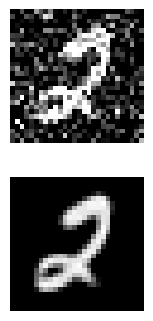

In [154]:
fig = plt.figure(figsize=(10, 4))
for i in range(1):
    ae.eval()
    idx = np.random.randint(0, len(noisy_train_dataset))

    plt.subplot(2, 5, i+1)
    plt.imshow(train_dataset[idx][0][0], cmap='gray')
    plt.axis('off')

    plt.subplot(2, 5, i+6)
    with torch.no_grad():
        output = ae(train_dataset[idx][0])
        output = output.squeeze().numpy()
        plt.imshow(output, cmap='gray')
        plt.axis('off')

De-noising data

In [283]:
def denoise(dataloader, model):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data.unsqueeze(1).float() / 255)
            preds.extend(output.squeeze().numpy())

    return preds

train_img = denoise(train_dataloader_noise, ae)
test_img = denoise(test_dataloader_noise, ae)

Loading de-noised data

In [284]:
train_img = np.array(train_img)
test_img = np.array(test_img)

train_img = train_img.reshape(-1, 28, 28)
test_img = test_img.reshape(-1, 28, 28)

train_label = training_data.targets.numpy()
print(train_label.shape)
test_label = test_data.targets.numpy()

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_img), torch.from_numpy(train_label))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_img), torch.from_numpy(test_label))

train_ratio = 0.85
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

(60000,)


In [288]:
def train(train_dataloader, val_dataloader, model, criterion, optimizer, epochs):
    #model.train()

    for epoch in range(epochs):
        train_loss, correct = 0, 0

        for batch_idx, (data, target) in enumerate(train_dataloader):
            optimizer.zero_grad()
           
            output = model(data.unsqueeze(1).float() / 255)
            loss = criterion(output, target)
            
            train_loss += loss.item()
            correct += output.argmax(dim=1, keepdim=True).eq(target.view_as(output.argmax(dim=1, keepdim=True))).sum().item()

            loss.backward()
            optimizer.step()
         
        train_loss /= len(train_dataloader)
        accuracy = correct / len(train_dataloader.dataset)

        val_loss, val_acc = validate(val_dataloader, model, criterion)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

def validate(val_dataloader, model, loss):
    #model.eval()
    val_loss, correct = 0, 0

    with torch.no_grad():
        for data, target in val_dataloader:
            output = model(data.unsqueeze(1).float() / 255)
            val_loss += loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_dataloader)
    accuracy = correct / len(val_dataloader.dataset)    

    return val_loss, accuracy

In [289]:
model = CNN(0, 5, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(train_dataloader, val_dataloader, model, criterion, optimizer, 10)

Epoch [1/10], Train Loss: 2.3019, Train Accuracy: 0.1104, Val Loss: 2.3017, Val Accuracy: 0.1102


KeyboardInterrupt: 

## 5

### 5.1

Loading Data

58000


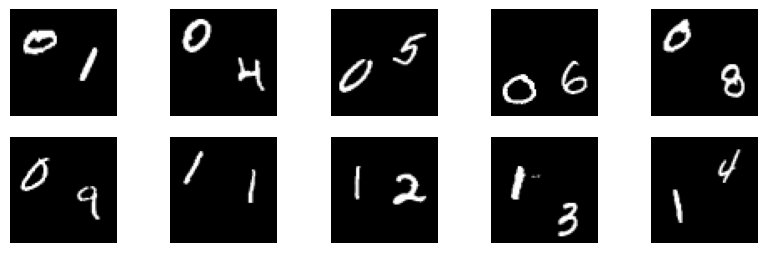

In [84]:
from torchvision import transforms
from sklearn.preprocessing import OneHotEncoder

data_dir = 'double_mnist_seed_123_image_size_64_64'  

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.ToTensor(),  
])

train_dataset = datasets.ImageFolder(root=data_dir + '/train', transform=transform)
val_dataset = datasets.ImageFolder(root=data_dir + '/val', transform=transform)
test_dataset = datasets.ImageFolder(root=data_dir + '/test', transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def filter_out_same_digit_images(dataset):
    filtered_dataset = []
    for image, label in dataset:
        a = label // 10
        b = label % 10

        if a != b:
            filtered_dataset.append((image, label))
    return filtered_dataset

train_dataset = filter_out_same_digit_images(train_dataset)
val_dataset = filter_out_same_digit_images(val_dataset)
test_dataset = filter_out_same_digit_images(test_dataset)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset))
#visualise some images
fig = plt.figure(figsize=(10, 8))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_dataset[i*1000][0][0], cmap='gray')
    plt.axis('off')

#### 5.1.1

In [87]:
# MLP on multi-mnist dataset

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(64 * 64, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print(x.shape)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        x = self.relu1(x)
        #print(x.shape)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

In [98]:
def ohe(labels):
    y = np.zeros((len(labels), 10))
    for i in range(len(labels)):
        y[i][labels[i]] = 1
    return y

from sklearn.metrics import hamming_loss
def train(train_loader, val_loader, model, criterion, optimizer, epochs):
    #model.train()

    # calclate accuracy using hamming loss

    for epoch in range(epochs):
        train_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            print(output.shape)

            #perform ohe on target
            target = ohe(target)
            loss = criterion(output, torch.from_numpy(target).long())
            
            train_loss += loss.item()

            loss.backward()
            optimizer.step()
         
        train_loss /= len(train_loader)
        val_loss, val_accuracy = validate(val_loader)

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

def validate(val_loader):
    #model.eval()
    val_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            target = ohe(target)
            val_loss += loss(output, target).item()

            y_true.append(target.numpy())
            y_pred.append((output > 0.5).numpy().astype(int))
            
    val_loss /= len(val_loader)
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    accuracy = 1 - hamming_loss(y_true, y_pred)       

    return val_loss, accuracy

In [99]:
#train the model
mlp = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

train(train_loader, val_loader, mlp, criterion, optimizer, 10)

torch.Size([64, 10])


IndexError: index 20 is out of bounds for axis 0 with size 10